In [1]:
from pedigree_functions import *
import tskit
import msprime
import stdpopsim
import networkx as nx
import matplotlib.pyplot as plt
import io
from IPython.display import display as SVG
import sys
import tszip
import pandas as pd
import numpy as np

C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [1]:
from pedigree_functions import *

C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
C:\Users\PHLUP\miniconda3\envs\masterarbeit\Lib\site-packages\stdpopsim\catalog\HomSap\demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


In [2]:
#set up and simulation
#requires: genomic map, SNP positions, parent genotypes
#builds: arbitrary pedigree, founder nodes
#simulates: ARG based on pedigree and genomic map, offspring genotypes of pedigree in ARG

#simulate genotypes of one population combination (e.g. pop 1 (B73×B97)S5)
#sim ancestry with pedigree similar to pop (~150 offspring + 5 selfing genos)
genmap = pd.read_csv("data/test_data/B73_genmap_chr1.csv")
chr1_rate_map = get_rate_map(genmap)

#set up pedigree
pop_1_ped_df = pedigree_init(n = 2) 
pop_1_ped_df = add_selective_mating(pop_1_ped_df, list([0,1]), offspring = 150)
for i in range(0, 5):
    pop_1_ped_df = add_selfing(pop_1_ped_df)
pop_1_ped = df_to_ts(pop_1_ped_df, seq_len=297570924)

#load snp positions
SNP_positions = pd.read_csv("data/test_data/NAM_SNP_positions.csv")

#reduce SNPs to chr1 of genetic map
chr_1_SNP_positions = SNP_positions[SNP_positions["Marker"].isin(genmap["Marker"])]

#read parent genotypes
parent_genos = pd.read_csv("data/test_data/NAM_parent_genos.csv")

#choose which parents to cross
founder_nodes = get_founder_nodes(parent_genos, list(["B73", "B97"]))

#simulate chromosome 1
chr1_arg = msprime.sim_ancestry(initial_state = pop_1_ped, model="fixed_pedigree", random_seed=42, recombination_rate = chr1_rate_map)

#propagate ARG recombinations to offspring genotypes
geno_sim = propagate_geno(chr1_arg, founder_nodes, chr_1_SNP_positions)

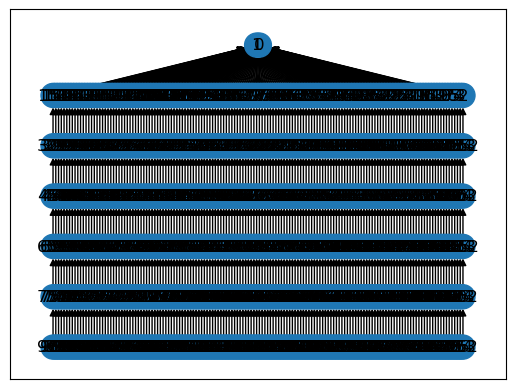

In [3]:
#results
draw_pedigree(pop_1_ped.tree_sequence())

In [4]:
get_offspring_geno(chr1_arg, geno_sim)

,node,PZA01271.1,PZA03613.1,PZA02129.1,PZA02032.1,PHM2244.142,PZA02372.1,PHM6238.36,PZA00181.2,PZA00528.1,...,PZA02359.10,PHM9807.9,PZA01068.1,PZA00343.31,PHM1275.22,PZA00243.25,PZA00856.2,PZA01239.2,PZA01807.1,PZA00432.4
710,1504,C,A,T,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
711,1505,C,A,T,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
712,1506,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
713,1507,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T
714,1508,G,A,T,T,G,T,A,T,C,...,T,C,C,A,A,G,T,A,G,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,1799,C,A,T,T,C,T,A,G,A,...,T,C,C,A,A,G,T,A,G,C
1006,1800,G,T,C,A,G,T,A,T,C,...,T,C,C,G,C,A,T,A,G,T
1007,1801,G,T,C,A,G,T,A,T,C,...,T,C,C,G,C,A,T,A,G,T
1008,1802,G,T,C,A,G,T,A,T,C,...,T,G,C,G,C,A,T,A,G,T


In [15]:
print(chr1_arg.dump_tables())

TableCollection

Sequence Length: 297570924.0
Time units: generations
Metadata: b''

Individuals
╔═══╤═════╤════════╤════════╤══════════════════╗
║id │flags│location│parents │metadata          ║
╠═══╪═════╪════════╪════════╪══════════════════╣
║0  │    0│        │  -1, -1│  {'file_id': '0'}║
║1  │    0│        │  -1, -1│  {'file_id': '1'}║
║2  │    0│        │    0, 1│  {'file_id': '2'}║
║3  │    0│        │    0, 1│  {'file_id': '3'}║
║4  │    0│        │    0, 1│  {'file_id': '4'}║
║5  │    0│        │    0, 1│  {'file_id': '5'}║
║6  │    0│        │    0, 1│  {'file_id': '6'}║
║7  │    0│        │    0, 1│  {'file_id': '7'}║
║8  │    0│        │    0, 1│  {'file_id': '8'}║
║9  │    0│        │    0, 1│  {'file_id': '9'}║
║10 │    0│        │    0, 1│ {'file_id': '10'}║
║11 │    0│        │    0, 1│ {'file_id': '11'}║
║12 │    0│        │    0, 1│ {'file_id': '12'}║
║13 │    0│        │    0, 1│ {'file_id': '13'}║
║14 │    0│        │    0, 1│ {'file_id': '14'}║
║15 │    0│        │ 

In [ ]:
#function to recast snp into 0,1,2 depending on encoding (in this case: B73 allele: 0, heterozygote 1, non-B73 allele: 2)

In [ ]:
#function to join nodes at individual level to reconstruct diploid genome
#get nodes per individual in offspring table, join rows in append(str(row1), str(row2))

In [7]:
#load snp positions
SNP_positions = pd.read_csv("data/test_data/NAM_SNP_positions.csv")

#reduce SNPs to chr1 of genetic map
chr_1_SNP_positions = SNP_positions[SNP_positions["Marker"].isin(genmap["Marker"])]
#chr_1_SNP_positions

In [1]:
#population one genotypes and allele frequencies
pop_1_genos = pd.read_csv("data/test_data/pop_1_genos.csv")
pop_1_chr_1 = pop_1_genos[pop_1_genos.columns.intersection(genmap["Marker"])]
pop_1_chr_1 = pop_1_chr_1.values.astype(int).tolist()
pop_1_chr_1_allele_freq = calc_allele_freq(pop_1_chr_1)

#pop_1_chr_1_allele_freq

NameError: name 'pd' is not defined

In [43]:
#calculate rogers and neis distance between real pop and simulated pop
#calculate allele frequencies
def calc_allele_freq(matrix, alleles = 3):
    num_individuals = len(matrix)
    num_snps = len(matrix[0])
    num_alleles = alleles
    allele_frequencies = []

    for j in range(num_snps):
        allele_counts = [0] * num_alleles

        for i in range(num_individuals):
            allele_counts[matrix[i][j]] += 1

        snp_frequencies = [count / num_individuals for count in allele_counts]
        allele_frequencies.extend(snp_frequencies)

    return allele_frequencies

#rogers distance

#neis distance
def neis_distance(X):
    #matrix product of X and its transpose
    d = np.matmul(X, X.T)
    
    #sqrt of diagonal elements
    vec = np.sqrt(np.diag(d))
    
    #Normalize columns of d
    d /= vec[:, np.newaxis]
    
    #Normalize rows of d
    d /= vec
    
    #negative logarithm
    d = -np.log(d)
    
    #todistance matrix
    d = np.asarray(d)
    
    return d

In [24]:
#examples for neis distance and allele frequency functions
X = np.array([[1.0, 3.0, 5.0], [2.0, 4.0, 6.0]])

In [25]:
X

array([[1., 3., 5.],
       [2., 4., 6.]])

In [25]:
neis_distance(X)

array([[-0.        ,  0.00616024],
       [ 0.00616024, -0.        ]])

In [50]:
#example (max distance of pop with 4 individauls vs 3 individuals)
matrix_1 = [
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 0]
]
matrix_2 = [
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [0, 1, 1, 1]
]

freq_1 = calculate_allele_frequency(matrix_1)
freq_2 = calculate_allele_frequency(matrix_2)
print(freq_2)

[0.3333333333333333, 0.6666666666666666, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]


In [51]:
X = np.array(list([freq_1, freq_2]))

In [52]:
neis_distance(X)

array([[-0.        ,  2.42601513],
       [ 2.42601513, -0.        ]])